# Assignment 1

## Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialdata2022/wiki/Assignment-1-and-2) carefully before proceeding. This page contains information about formatting (including formats etc.), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Monday February 28th, 2022 at 23:59. Hand in your files via [http://peergrade.io](http://peergrade.io/).

**Peergrading date and time**: _Remember that after handing in you have 1 week to evaluate a few assignments written by other members of the class_. Thus, the peer evaluations are due on Monday March 7th, 2022 at 23:59.

## Part 1: Visualizing patterns in the data

In this exercise, please generate the visualizations described below. Use the same date-ranges as in Week 2. For each set of plots, describe the plots (as you would in the figure text in a report or paper), and pick a few aspects that stand out to you and comment on those (we provided a couple of ideas during class but it's OK to add more).

We look only at the focus-crimes in the exercise below.

In [1]:
focuscrimes = ['WEAPON LAWS', 'PROSTITUTION', 'DRIVING UNDER THE INFLUENCE', 'ROBBERY', 'BURGLARY', 'ASSAULT', 'DRUNKENNESS', 'DRUG/NARCOTIC', 'TRESPASS', 'LARCENY/THEFT', 'VANDALISM', 'VEHICLE THEFT', 'STOLEN PROPERTY', 'DISORDERLY CONDUCT']

> *Exercise*: 
>
> * *Weekly patterns*. Basically, we'll forget about the yearly variation and just count up what happens during each weekday. [Here's what my version looks like](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/weekdays.png). Make your own version of the plot and comment your results.
> * *Hours of the week*. But by looking at just 24 hours, we may be missing some important trends that can be modulated by week-day, so let's also check out the 168 hours of the week. So let's see the number of each crime-type Monday night from midninght to 1am, Monday night from 1am-2am - all the way to Sunday night from 11pm to midnight. Visualize and comment your results.
> * *Spatial patterns*. Next, we want to generate a slightly more complicated graphic. I'm interested to know if there are certain crimes that happen much more in certain neighborhoods than what's typical:
>    - For each district plot the ratio `P(crime|district)/P(crime)` for the 14 focus crimes (follow and *show* the steps in Week 2 Ex. 2.2 for success).
>    - Comment on the top crimes in _Tenderloin_, _Mission_, and _Richmond_. Does this fit with the impression you get of these neighborhoods on Wikipedia?

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [3]:
df_raw = pd.read_csv('Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv')

df_raw.Date = pd.to_datetime(df_raw['Date']) + pd.to_timedelta(df_raw['Time'] + ':00')

df_no_2018 = df_raw[df_raw.Date.dt.year < 2018]
df = df_no_2018[df_no_2018.Category.isin(focuscrimes)]

### Weekly patterns

C:\Users\moeso\AppData\Roaming\Python\Python37\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


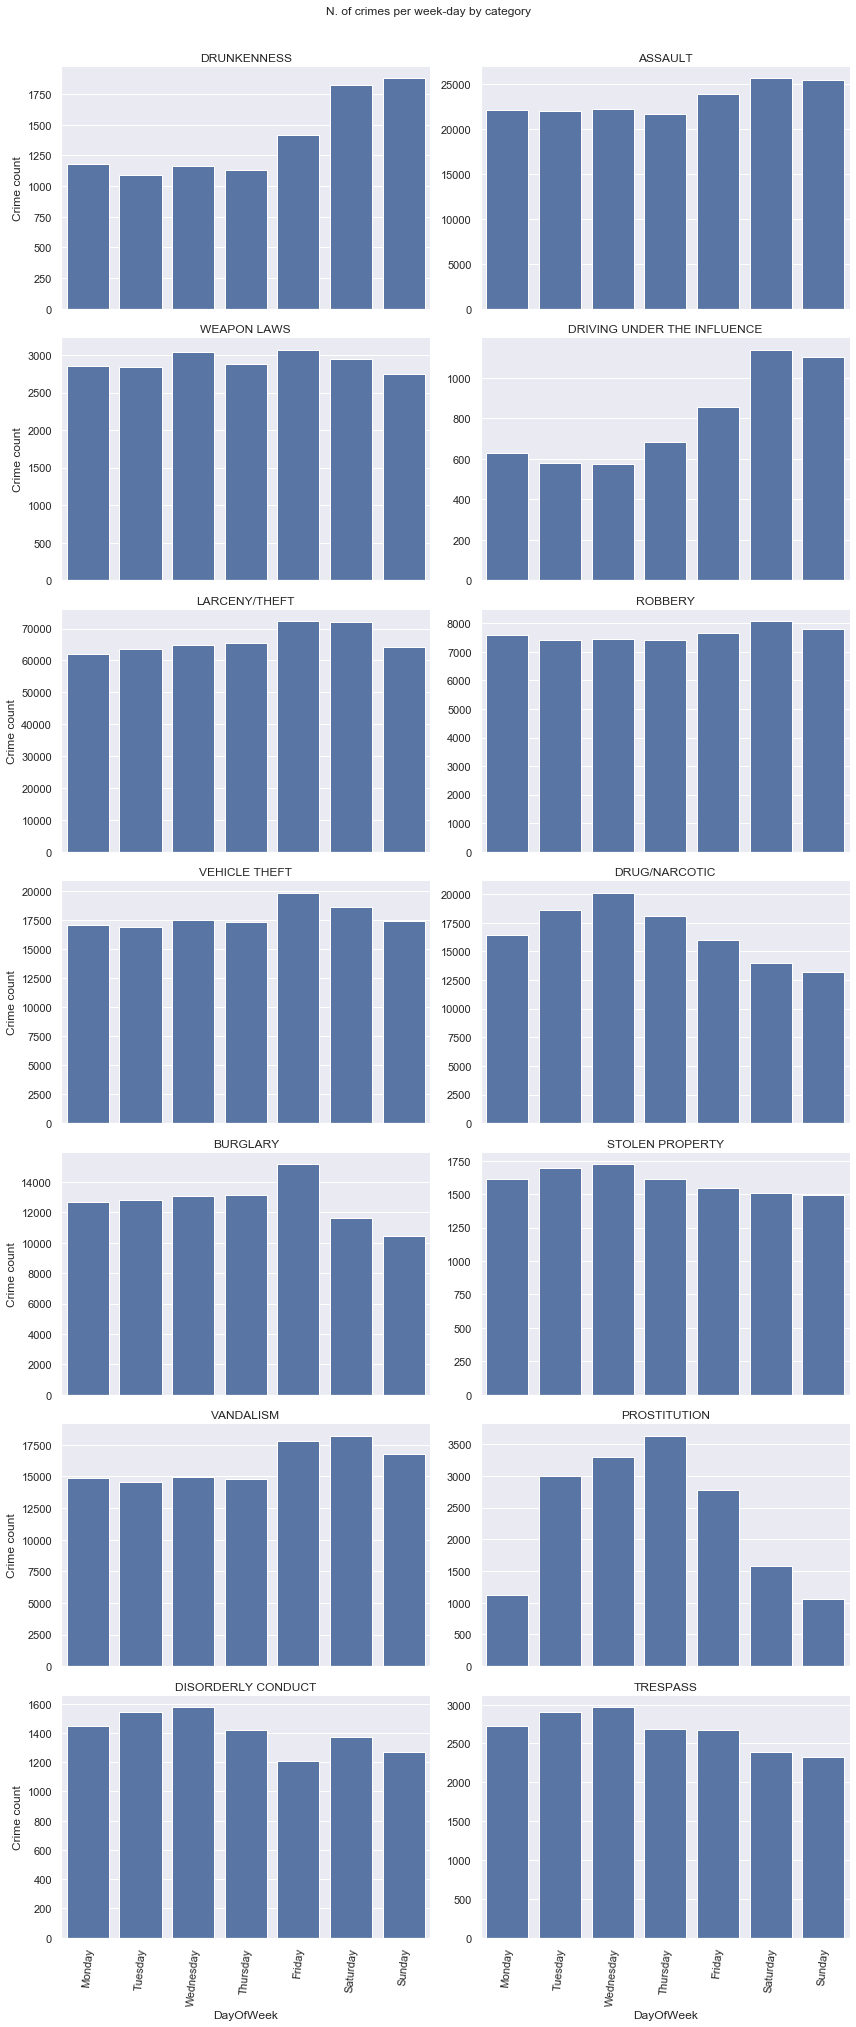

In [4]:
sorter = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sorterIndex = dict(zip(sorter, range(len(sorter))))

df_plot = df.groupby([df.Category, df.DayOfWeek]).count().IncidntNum.reset_index()
df_plot['sort_idx'] = df_plot.DayOfWeek
df_plot['sort_idx'] = df_plot['sort_idx'].map(sorterIndex)
df_plot = df_plot.sort_values('sort_idx')

g = sns.FacetGrid(df_plot, col='Category', height=4, aspect=1.5, col_wrap=2, sharey=False)
g.map(sns.barplot, "DayOfWeek", "IncidntNum")
g.set_ylabels('Crime count')
g.set_titles('{col_name}')
g.set_xticklabels(rotation=85)
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('N. of crimes per week-day by category')
plt.show()

Patterns in this visualization show more burglary on friday's, more prostitution in the middle of the week!, vehicle theft on fridays and drunkness on weekends. Funny enough, more people are caught with driving under the influence on a saturday probably due to hangovers haha. Finally, people like to do drugs in the middle of the week instead of the weekends, at least those who get caught do.

### Hours of the week

In [5]:
df['hour_of_the_week'] = df['Date'].dt.dayofweek * 24 + df['Date'].dt.hour

C:\Users\moeso\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


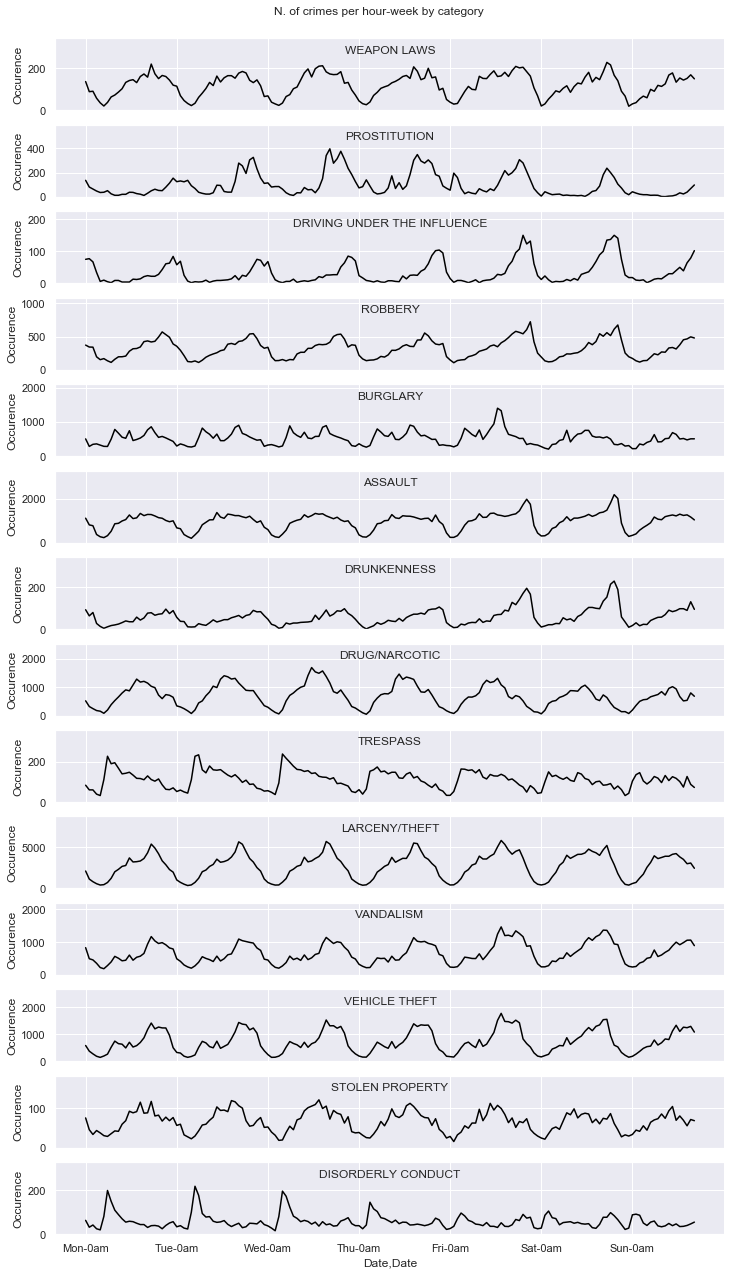

In [6]:
fig, ax = plt.subplots(nrows=14, ncols=1, figsize=(12, 22), sharex=True)
fig.suptitle('N. of crimes per hour-week by category', y=0.9)

i = 0
for row in ax:
    crimeGroupByHourWeek = df[df['Category'] == focuscrimes[i]].groupby([df.Date.dt.weekday, df.Date.dt.hour]).size()
    crimeGroupByHourWeek.plot(ax=row, color='black')

    row.set_ylabel("Occurence")
    row.set_title(focuscrimes[i], y=1, pad=-15)
    row.set_ylim([0, 1.5 * crimeGroupByHourWeek.max()])
    row.set_xticklabels(['', 'Mon-0am', 'Tue-0am', 'Wed-0am', 'Thu-0am', 'Fri-0am', 'Sat-0am', 'Sun-0am', '', ''])

    i += 1

This plot is essentially a higher resolution plot of the 'weekly patterns' where we in addition to seeing the trends pr day of the week, we also see the hours per each day of the week. Overall, it shows the same patterns as the weekly patterns. However, we are able to spot a few patterns that were not apparent in the other plot. Such as disorderly conduct happening mostly in the first 3 days of the week in the morning. Moreover, the number of assaults and drunkenness also increase during the night on Friday's and Saturday's. Also, we know that there are more burglaries on Friday, but now we see that they happen late in the day.

### Spatial patterns

In [7]:
# Probability of crime per category
P_crime = df.groupby('Category').count()['IncidntNum'] / len(df)
P_crime = P_crime.rename('Prob')

In [8]:
# Count of crimes per category for each district
P_crime_district = (df.groupby(['PdDistrict', 'Category']).count()['IncidntNum']).reset_index()

# Crimes per district to normalize per district
crimes_pr_district = P_crime_district.groupby('PdDistrict').sum().to_dict()['IncidntNum']

In [9]:
# Normalize per district
P_crime_district['Prob'] = P_crime_district.apply(lambda x: x.IncidntNum / crimes_pr_district[x.PdDistrict], axis=1)

In [10]:
P_crime_district.Prob.sum()

10.0

We have 10 districts, so the sum of probabilities should be 10.

In [11]:
P_ratio = P_crime_district.join(P_crime, on='Category', lsuffix='District', rsuffix='City')
P_ratio['Ratio'] = P_ratio.ProbDistrict / P_ratio.ProbCity

In [12]:
P_ratio.head()

,PdDistrict,Category,IncidntNum,ProbDistrict,ProbCity,Ratio
0,BAYVIEW,ASSAULT,19538,0.178262,0.134314,1.327203
1,BAYVIEW,BURGLARY,9442,0.086147,0.073242,1.176200
2,BAYVIEW,DISORDERLY CONDUCT,538,0.004909,0.008099,0.606095
3,BAYVIEW,DRIVING UNDER THE INFLUENCE,448,0.004087,0.004577,0.893036
4,BAYVIEW,DRUG/NARCOTIC,9569,0.087306,0.095782,0.911503


C:\Users\moeso\AppData\Roaming\Python\Python37\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


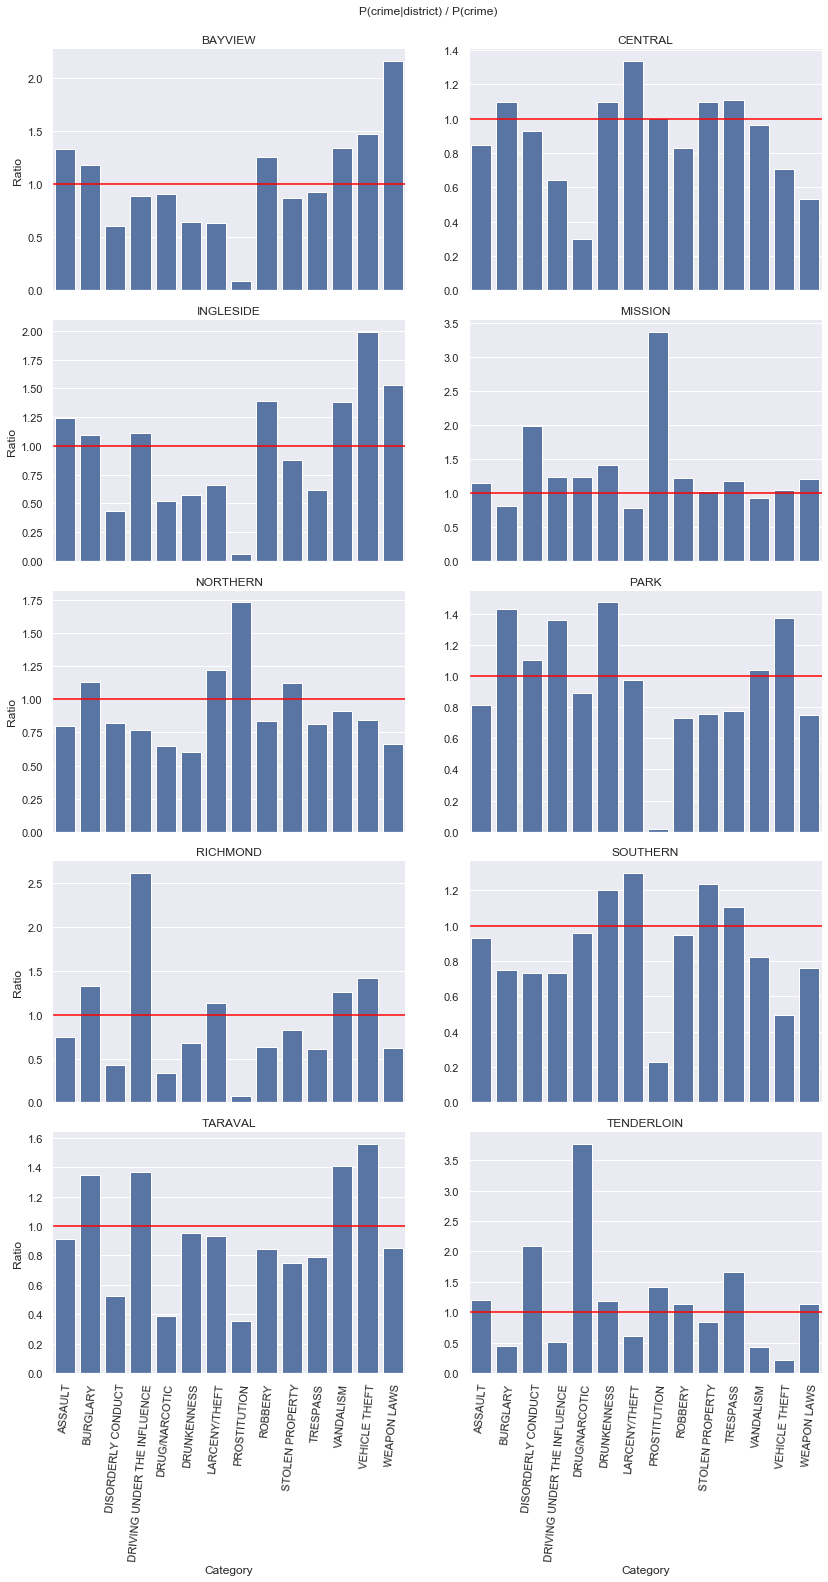

In [13]:
g = sns.FacetGrid(P_ratio, col='PdDistrict', height=4, aspect=1.5, col_wrap=2, sharey=False)
g.map(sns.barplot, "Category", "Ratio")

for ax in g.axes:
    ax.axhline(1, color='red')

g.set_ylabels('Ratio')
g.set_xlabels('Category')
g.set_titles('{col_name}')
g.set_xticklabels(rotation=85)
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('P(crime|district) / P(crime)')
plt.show()

## Part 2: Fundamentals of data visualization

In the exercise below, there is a selection of questions from Week 3, Part 1. Please, check it out if you have any doubt on how to solve the exercise.

> *Exercise:* 
>
> * *Questions from the [lecture](https://www.youtube.com/watch?v=yiU56codNlI)*. Sune mentions in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it. 
> * *Hypothesis testing*. Use [data 1](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_f.csv) and [data 2](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_m.csv) to verify whether there is a statistically significant difference in the average number of steps taken by men and women. 
>     * Is there a statistically significant difference between the two groups? What is the difference between their mean number of steps? Plot two histograms to visualize the step-count distributions, and use the criterion you chose in the previous step to define the right bin-size and comment on your choice.
>     * **Pretend you did not visualize the data yet.** What was the explanation you found for what you observed? Explain the theory, news, papers, further analysis etc. you used to support your conclusions and write down a couple of sentences. Now, think of the actual shape of the data: what do you think the point of this exercise was? 
> * *Scatter plots.* Create a scatter plot with both data samples by using **your own alternative** to `color='#f6756d'` and `color='#10bdc3'`. Explain why you chose this visualization, its pros, and cons.

### Questions from the lecture

> * I mention in the video that it's important to choose the right bin-size in histograms. But how do you do that? Do a Google search to find a criterion you like and explain it.
> **Answer:** A common approach is that $numberofbins = ceil( \frac{(maximumvalue - minimumvalue)}{binwidth})$ that accounts for the range of the data (width in the plot) divided by the bin width which gives you how many bins there are room for in the range.
> Another common approach, which is more a rule of thumb is _Sturge's Rule_ given by the formula: $K = 1 + 3.222 \log_N$ [\[1\]](https://www.statisticshowto.com/choose-bin-sizes-statistics/). It works best for normally distributed and continuous data that is not skewed.
> Finally, there is _Scott's Rule_ as an alternative to _Sturge's Rules_ that uses the standard deviation of the data in the formula: $3.49 \sigma n^{-\frac{1}{3}}$

### Hypothesis testing

In [14]:
female = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_f.csv")
male = pd.read_csv("https://raw.githubusercontent.com/suneman/socialdata2022/main/files/data9b_m.csv")

In [15]:
from scipy.stats import ttest_ind

res = ttest_ind(female['steps'], male['steps'])

print(f'Is there a significant difference between male and female step counts? {res.pvalue < 0.05}')

Is there a significant difference between male and female step counts? True


In [16]:
print(f"Difference in mean number of steps: {(female.steps.mean() - male.steps.mean()):.0f}")

Difference in mean number of steps: -935


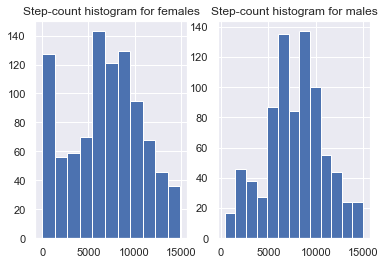

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2)
female['steps'].hist(bins='scott', ax=ax1)
ax1.set_title('Step-count histogram for females')

male['steps'].hist(bins='scott', ax=ax2)
ax2.set_title('Step-count histogram for males')

plt.show()

We choose _Scott's rule_ as the data is not nicely normal distributed. The plot also gives clear indication that we capture enough irregularities without being too narrow. Such as the significant spike for females around 0 and the dip in the middle of the bellcurve for men

**Explanation for our findings:** A study has found that females walk less than males [\[2\]](https://www.medicalnewstoday.com/articles/average-steps-per-day#:~:text=The%20Medicine%20and%20Science%20in,around%204%2C912%20steps%20per%20day.). Which is also the case for our findings. As there was a significant difference in the t-test and the mean shows that females walk around 950 steps less.

From the scatterplot it is obvious that the point is to show that one can perform a plethora of statistical analysis but without visualization we will rarely be able to understand the nature of the data. Which in this case is that it's clearly user-made and does not actually represent the step count vs bmi relationship for men and women.

### Scatter plots

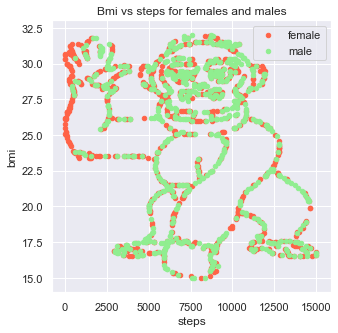

In [18]:
f, ax1 = plt.subplots(1, 1, figsize=(5, 5))
female.plot(kind='scatter', x='steps', y='bmi', color='tomato', ax=ax1, label='female')
ax1.set_title('Bmi vs steps for females and males')
male.plot(kind='scatter', x='steps', y='bmi', color='lightgreen', ax=ax1, label='male')
plt.legend()
plt.show()

We chose this visualization as it supports both normal and colorblind vision (tested on https://www.color-blindness.com/coblis-color-blindness-simulator/). The scatterplot shows us patterns in the data which is clearly a monkey here. Indicating that the data is fake.

## Part 3: Different types of visualization from DAOST

The exercise below, is a selection of questions from Week 3, Part 2 and 3.

> *Exercise:*
>
> * *Questions from DAOST*
>     * Janert, the author of DAOST, is so suspicious of mean, median, and related summary statistics. Explain why one has to be careful when using those - and why visualization of the full data is always better. 
>     * Explain what is a box plot. When are box plots most useful? Are violin plots better or worse than box plots? Why?
> * *Recreating plots from DAOST*. We need some box plots. Here, I'd like you to use the box plots to visualize fluctuations of how many crimes happen per day. We'll use data from the 15 focus crimes defined in Part 1.
>     * For the full time-span of the data, calulate the **number of crimes per day** within each category for the entire duration of the data.
>     * Create a box and whiskers plot showing the mean, median, quantiles, etc. for all 15 crime-types side-by-side. What does this plot reveal that you can't see in the plots from previous weeks?
>     * Now, let's calculate another average for each focus-crime, namely what time of day the crime happens. So this time, the distribution we want to plot is the average time-of-day that a crime takes place. There are many ways to do this, but let me describe one way to do it: 
>        * For datapoint, the only thing you care about is the time-of-day, so discard everything else.
>        * You also have to deal with the fact that time is annoyingly not divided into nice units that go to 100 like many other numbers. (Refer to Week 3 exercise 3.2 for hints.)      
>        * Now, you can create box-plots to create an overview of *when various crimes occur*. Note that these plot have quite a different interpretation than ones we created in the previous exercise. Comment your results. 

### Question from DAOST

If the data distribution is symmetric and does not have any important outliers, we can use mean and median. But if there are many outliers or our data is not symmetric, mean and median are not good choices to see the whole distribution of the data

Box plot is useful when we want to see the whole distribution of the data, especially the data has important outliers, also box plot can see the differences between several distibutions. In addition, violin plot includes probability density as well, it can give people more information about the data.

### Recreating plots from DAOST

In [19]:
df_plot = df_raw[df_raw.Category.isin(focuscrimes)]

C:\Users\moeso\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


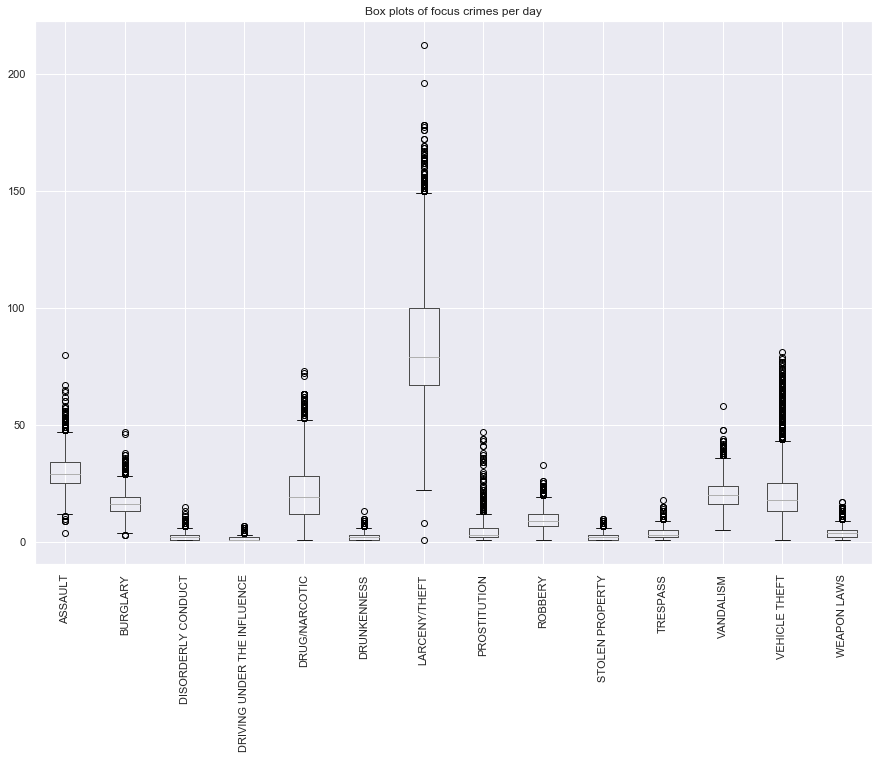

In [20]:
df_plot.groupby([df_plot.Date.dt.floor('d'), df_plot.Category])\
    .count()['PdId']\
    .reset_index()\
    .pivot_table('PdId', ['Date'],'Category')\
    .boxplot(figsize=(15, 10))
plt.xticks(rotation=90)
plt.title('Box plots of focus crimes per day')
plt.show()

This time we are shown the outliers as well as the summary statistics for each category

In [21]:
df_new = df_plot[['Category', 'Date']]

In [22]:
df_new['hour'] = df_new.Date.dt.hour

C:\Users\moeso\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


C:\Users\moeso\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


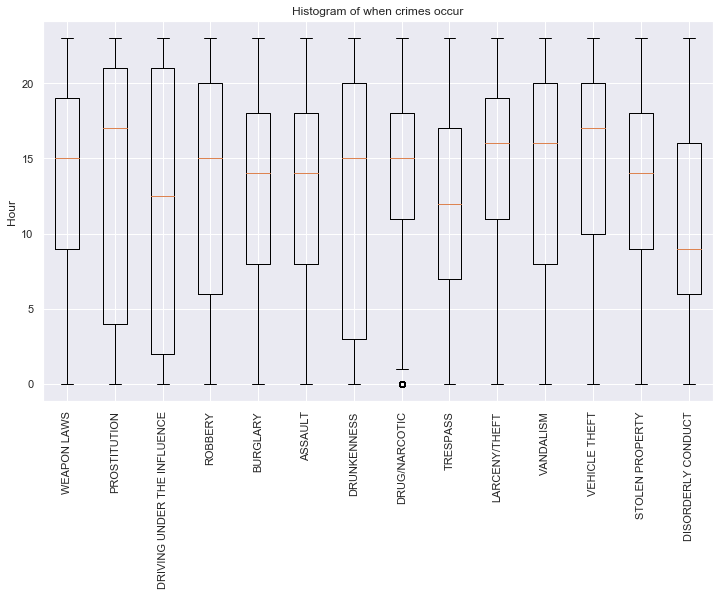

In [23]:
fig, ax = plt.subplots(figsize=(12, 7))

data = []

for crime in focuscrimes:
    cat = df_new.query(f"Category == '{crime}'")
    data.append(cat['hour'])

ax.set_xticklabels(focuscrimes, rotation=90)
ax.boxplot(data)
ax.set_title('Histogram of when crimes occur')
ax.set_ylabel('Hour')
plt.show()


In general, 50% of most crimes happen in the between hours 12 to 16. For driving under the influence, it is more spread out. However, this is slightly misleading as we could have large chunks of data in either tail (hour 0 to 1, and hour 23 to 0) which would skew the quantiles to either side. Whilst not actually having much data in the 'middle' around hour 12 for example. For drug use, it seems to be concentrated around hour 15. And disorderly conduct is mostly in the mornings.

## PART 4: Visualizing geo-data

Let's now use the cool Folium functionalites `HeatMap` and `HeatMapWithTime` to create a visualization of the patterns of your favorite crime-type and how they change over time. 

**Note** The exercise below is a mix of exercise 1.2 (**but with the data you choose**) and 1.3 from Week 4.

> *Exercise*: Heatmaps and heatmap movies. you get to make all the choices, but remember to **explain and motivate them**.
> * Start by choosing a crimetype with spatial patterns that change over time. Use your data-exploration from the previous lectures to choose a good one.
> * Create a heatmap by grabbing your crimetype data across all times. Play with parameters to get plots you like and explain why you chose them and what the effect of these parameters are.
> * Now, choose a time-resolution. You could plot daily, weekly, monthly datasets to plot in your movie. Again the goal is to find interesting temporal patterns to display. We want at least 20 frames though. Create the movie using `HeatMapWithTime`.
> * Comment on your results: 
>   - What patterns does your movie reveal?
>   - Motivate/explain the reasoning behind your choice of crimetype and time-resolution (you can also refer to exercises/visualizations that we have done in class to motivate your choice). 

In [24]:
import folium

In [25]:
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [26]:
lat, lon = 37.7749, -122.4194

df_res = df_raw[df_raw.Category == 'SEX OFFENSES, NON FORCIBLE']

**Explain and motivate**
We will try to plot sex offenses that aren't forced to see where these unconventional crimes take place. This could lead to valuable insights on where to focus when trying to prevent these types of crimes

In [27]:
# Playing around with params
map_sf = folium.Map([lat, lon],
                    tiles='Stamen Toner',
                    zoom_start=13)

HeatMap([[row.Y, row.X] for index, row in df_res.iterrows()],
        min_opacity=.5,
        radius=25,
        blur=20,
        gradient={0.3: 'blue', 0.6: 'lime', 1: 'red'}).add_to(map_sf)

map_sf

- Playing around with parameters:
- > `min_opacity` determines how transparent low-density points can be. A value of 0.001 produces very transparent groups whilst a value of 1 produces almost all-red groups which makes it hard to distinguish between them. It is set to 0.5 as it shows the best difference between the groups.
- > `radius` determines the _radius_ of the heatmap groups. It seems that increasing the value from the default of 25 gives more connected and non-circular groups. Kind of like increasing the $\varepsilon$ parameter in DBScan. We keep it at the default to have concentrated areas of crimes.
- > `blur` determines the _intensity_ of the heatmap groups. The default is 15 and higher values give less intense groups whilst lower values give more intense groups in terms of the color gradient. In combination with the gradient, it shows distinguished groups.
- > `gradient` determines the color of the heatmap groups. Used with blur to show distinguished groups.

In [28]:
# Time resolution
time_res = range(0, 24)

# Crime
CRIME = 'DRIVING UNDER THE INFLUENCE'

# Data
df_heat = df[df.Category == CRIME]

intensity = 0.5
data = [
    [ [row.Y, row.X, intensity] for idx, row in df_heat[df_heat.Date.dt.hour == hour].iterrows()]
    for hour in time_res
]

In [29]:
map_sf = folium.Map([lat, lon],
                    tiles='Stamen Toner',
                    zoom_start=13)

HeatMapWithTime(data,
                auto_play=True,
                max_opacity=0.8,
                ).add_to(map_sf)

map_sf

What patterns does your movie reveal?
- We see that there are a lot of people driving drunk in the night and evening hours (21+ h). They seem to be caught mainly in downtown, the west highway or the south-west highway. There are more arrests on the west highway after 00h.

Motivate/explain the reasoning behind your choice of crimetype and time-resolution.
- We choose this crimetype as it's shown in Week 2 that it is highly time dependent with respect to a time-resolution of 24h. There are significantly more arrests in the night than during the day. The heatmap now shows us where this happens.

## Part 5: Errors in the data. 

We started the course by plotting simple histogram and bar plots that showed a lot of cool patterns. But sometimes the binning can hide imprecision, irregularity, and simple errors in the data that could be misleading. In the work we've done so far, we've already come across at least three examples of this in the SF data. 

1. In the temporal activity for `PROSTITUTION` something surprising is going on on Thursday. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/prostitution.png), where I've highlighted the phenomenon I'm talking about.
2. When we investigated the details of how the timestamps are recorded using jitter-plots, we saw that many more crimes were recorded e.g. on the hour, 15 minutes past the hour, and to a lesser in whole increments of 10 minutes. Crimes didn't appear to be recorded as frequently in between those round numbers. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/jitter.png), where I've highlighted the phenomenon I'm talking about.
3. And, during Week 4 we saw that the Hall of Justice seemed to be an unlikely hotspot for sex offences. Remind yourself [**here**](https://raw.githubusercontent.com/suneman/socialdata2022/main/files/crime_hot_spot.png).

> *Exercise*: Data errors. The data errors we discovered above become difficult to notice when we aggregate data (and when we calculate mean values, as well as statistics more generally). Thus, when we visualize, errors become difficult to notice when binning the data. We explore this process in the exercise below:
>
> * In each of the examples above, describe in your own words how the data-errors, I call attention to above, can bias the binned versions of the data. Also, briefly mention how not noticing these errors can result in misconceptions about the underlying patterns of what's going on in San Francisco (and our modeling).
> * Find your own example of human noise in the data and visualize it. Comment your results.

**Part 1**
1. The spike in prostitution will lead to a Thursday-bin in a DayOfTheWeek plot that is larger than the other bins in the plot. This could lead to the user or model thinking that prostitution happens more on Thursday's than other days, since the error-spike can't be seen in the low resolution binning.
2. The bias will mostly influence minute-level resolution bins as it will aggregate the 'real' timestamps into the 10, 15 or 60-minute bins. This could lead to weird looking distributions if one decides to look at a 1-minute bin histogram. For example, all assaults in the time interval 00-01. It will be hard to see the exact time, but generally it won't have a significant effect as the general trend is still seen. With respect to modelling, it could bias the model to predict that crimes only happen in these strict 15 minute intervals or even worse, once per hour.
3. If you bin the prostitution data in a histogram of latitude or longitude, you would see a concentration of prositution in one location more than others. That bin would be greatly affected by this and be relatively much larger than the other bins. This could lead to a misinterpretation of the area with most prosecution. With respect to modelling it would greatly bias the model to predict a lot of prostitution to happen at the Hall of Justice.

**Part 2**

In [30]:
df.describe()

,PdId,IncidntNum,Incident Code,X,Y,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,...,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2,hour_of_the_week
count,1.214753e+06,1.214753e+06,1.214753e+06,1.214753e+06,1.214753e+06,1.211582e+06,1.214229e+06,1.214410e+06,1.214224e+06,1.211818e+06,...,249762.000000,302018.000000,320049.000000,1.214224e+06,180600.0,181198.0,266956.000000,62036.000000,1.211582e+06,1.214753e+06
mean,1.024691e+13,1.024691e+08,1.045354e+04,-1.224228e+02,3.777202e+01,5.200041e+01,4.849202e+00,6.841880e+00,2.195696e+01,8.568204e+00,...,2.136626,13.924342,6.266050,1.579617e+00,1.0,1.0,2.321083,35.706477,5.200041e+01,8.664845e+01
std,4.520873e+12,4.520873e+07,8.511312e+03,2.916592e-02,4.000042e-01,3.190964e+01,2.738034e+00,3.365569e+00,1.254772e+01,4.287036e+00,...,1.192029,6.197364,2.583058,4.936206e-01,0.0,0.0,1.350391,9.740184,3.190964e+01,4.764857e+01
min,6.238907e+09,6.238900e+04,3.011000e+03,-1.225136e+02,3.770788e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000,1.000000,1.000000,1.000000e+00,1.0,1.0,1.000000,2.000000,1.000000e+00,0.000000e+00
25%,6.093490e+12,6.093490e+07,6.221000e+03,-1.224329e+02,3.775626e+01,2.400000e+01,3.000000e+00,3.000000e+00,9.000000e+00,5.000000e+00,...,1.000000,9.000000,5.000000,1.000000e+00,1.0,1.0,1.000000,35.000000,2.400000e+01,4.400000e+01
50%,1.009094e+13,1.009094e+08,6.313000e+03,-1.224168e+02,3.777563e+01,4.200000e+01,5.000000e+00,8.000000e+00,2.100000e+01,9.000000e+00,...,3.000000,15.000000,6.000000,2.000000e+00,1.0,1.0,3.000000,35.000000,4.200000e+01,8.900000e+01
75%,1.408460e+13,1.408460e+08,1.602000e+04,-1.224070e+02,3.778513e+01,8.400000e+01,7.000000e+00,1.000000e+01,3.400000e+01,1.300000e+01,...,3.000000,18.000000,7.000000,2.000000e+00,1.0,1.0,3.000000,35.000000,8.400000e+01,1.290000e+02
max,9.911290e+13,9.911290e+08,6.506000e+04,-1.205000e+02,9.000000e+01,1.170000e+02,1.000000e+01,1.100000e+01,4.100000e+01,1.500000e+01,...,5.000000,25.000000,15.000000,2.000000e+00,1.0,1.0,5.000000,80.000000,1.170000e+02,1.670000e+02


Hmm... The max values for X and Y seem strange. The Y is 90 vs an average of 37.7, for X its -120 vs an average of -122.
Let's inspect it

In [31]:
idx = df.X.idxmax()

In [32]:
weird_row = df.iloc[idx,]

In [33]:

map_sf = folium.Map([weird_row.Y, weird_row.X],
                    tiles='Stamen Toner',
                    zoom_start=1)

folium.Marker([weird_row.Y, weird_row.X], popup=f"{weird_row.Category}").add_to(map_sf)

map_sf

We see that the first row in the dataset has a 'LARCENY/THEFT' datapoint located in the North Pole.

Other cases of human noise could be in entering the GPS coordinates of a crime.